[[ 0.1    0.111  0.122  0.133  0.144  0.155  0.166  0.177  0.188  0.199
   0.21   0.221  0.232  0.243  0.254  0.265  0.276  0.287  0.298  0.309
   0.32   0.331  0.342  0.353  0.364  0.375  0.386  0.397  0.408  0.419
   0.43   0.441  0.452  0.463  0.474  0.485  0.496  0.507  0.518  0.529
   0.54   0.551  0.562  0.573  0.584  0.595  0.606  0.617  0.628  0.639
   0.65   0.661  0.672  0.683  0.694  0.705  0.716  0.727  0.738  0.749
   0.76   0.771  0.782  0.793  0.804  0.815  0.826  0.837  0.848  0.859
   0.87   0.881  0.892  0.903  0.914  0.925  0.936  0.947  0.958  0.969
   0.98   0.991  1.002  1.013  1.024  1.035  1.046  1.057  1.068  1.079
   1.09   1.101  1.112  1.123  1.134  1.145  1.156  1.167  1.178  1.189]]


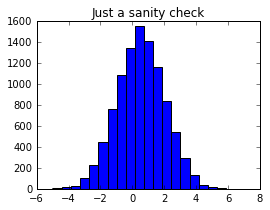

In [1]:
"""
The purpose of this notebook is to test our method on a synthetic, simple (but nontrivial)
example that we can use as a first try at experiments. This is based on Section 5.1 of
"Bayesian Learning via Stochastic Gradient Langevin Dynamics" (2011). We already know the 
true posterior distribution of this (we can compute a contour plot of that), so it is useful 
to see if our method can obtain the same posterior distribution of the parameters, theta.

We'll generate our data right here. Throughout this code, think of any "theta" variable as
being a 2-D (column) vector. So as far as I can tell:

1. The prior is N(0, diag(10,1)), with a diagonal covariance matrix.
2. The data is generated as a Gaussian Mixture Model. With 50% chance, we draw from
    N(theta[0],2), and with 50% chance, we draw from N(theta[0]+theta[1],2) where theta 
    is the 2-D vector with theta[0] as the first element, and theta[1] as the second. 
    But actually, we *know* the data is drawn from (0,1).
3. What this means is that p(x_i | theta) is going to be based on the *sum* of two 
    different Gaussian PDFs. So when we take logs, we get log(0.5*exp(...)+0.5*exp(...)) 
    so sadly, we cannot eliminate the exponentials.
4. The posterior is the prior times the likelihoods (from (3)) and has a contour plot 
    that we can plot, and which matches the SGLD 2011 paper's plot, so we're OK with
    that. Well, assuming we only use the 100 samples they used (but we need a lot more 
    to see differences!).

Right now, I'm comparing "Our Method" versus the "Cutting the MH" method. Technically, the 
latter should be called "Adaptive Minibatch MH" but the "Cutting the MH" is the title of 
the paper and it is easier to distinguish.

UPDATE (May 17, 2016): Now we have correct X_corr data.
"""

# Import a bunch of stuff ...
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import t
import sys
import scipy.io
from bisect import bisect


# VERY important, the number of points. The SGLD paper only used 100, but we need more.
N = 10000

# Generate the data according to Section 5.1 of "Bayesian Learning via SGLD" (2011).
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Generate the data matrix. Note that the np.random.normal(...) requires STD (not VAR).
X = np.zeros(N)
for i in xrange(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

# Visualize the data (strictly as a sanity check; we don't need to see it).
plt.figure(figsize=(4,3))
plt.title("Just a sanity check")
plt.hist(X, bins=20)

# Load some of Haoyu's stuff in advance. This will pre-load in the X_corr stuff we need.
# See the code later for example ussge.
mat = scipy.io.loadmat('../generateXcorr/XcorrCurves.mat')
ecdfmat = mat['res']
sd_vect = mat['sdval']
print(sd_vect.T)

log_f([0,1]) = -18200.1079355, N = 10000


(array([   1.,    1.,    2.,    4.,    3.,    8.,    4.,   18.,   23.,
          26.,   62.,   64.,   86.,  119.,  133.,  108.,  102.,   76.,
          59.,   44.,   19.,   18.,    8.,    5.,    2.,    0.,    0.,
           3.,    1.,    1.]),
 array([-7.11      , -6.62316667, -6.13633333, -5.6495    , -5.16266667,
        -4.67583333, -4.189     , -3.70216667, -3.21533333, -2.7285    ,
        -2.24166667, -1.75483333, -1.268     , -0.78116667, -0.29433333,
         0.1925    ,  0.67933333,  1.16616667,  1.653     ,  2.13983333,
         2.62666667,  3.1135    ,  3.60033333,  4.08716667,  4.574     ,
         5.06083333,  5.54766667,  6.0345    ,  6.52133333,  7.00816667,
         7.495     ]),
 <a list of 30 Patch objects>)

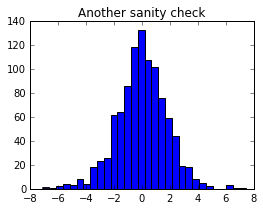

In [7]:
""" Define some functions. """

def log_f(theta, X, N, T):
    """
    The function 'f' is the posterior:
    
        f(theta) \propto p(\theta) * \prod_{i=1}^N p(x_i | \theta)
    
    There are therefore two components. Also, for speed, I try to vectorize. X is assumed 
    to be of shape (n,) so we can reshape it into (n,1). For obvious reasons, we take logs.
    
    Finally, we need to rescale the log likelihood part by N/len(X), just like what is done 
    in many papers. It helps to rescale the terms so that the prior doesn't overly influence
    values if we have minibatches of data. Here, X can be the full data (size N) or a subset.
    If X is the full data, this scaling has no effect. ALSO ... we have T > 1, a temperature
    parameter so we can decrease this factor as needed to make the distribution warmer. This
    means the distribution becomes flatter. It only affects the likelihood, not the prior.
    
    We use [0,0] because we really get a float in two lists, [[x]], so calling [0,0] gets x.
    """
    scale_and_temp = N / float(len(X) * T)
    
    inverse_covariance = np.array([[0.1,0],[0,1]])
    prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
    prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
    X_all = X.reshape((len(X),1))
    ll_constant = (1.0 / (4*np.sqrt(np.pi)))
    L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
    log_likelihood = np.sum(np.log(L)) * scale_and_temp
    
    assert (N / float(len(X))) >= 1
    assert not np.isnan(prior + log_likelihood)
    return (prior + log_likelihood)[0,0]
    

def get_noise(eps):
    """ Returns a 2-D multivariate normal vector with covariance matrix = diag(eps,eps). """
    return (np.random.multivariate_normal(np.array([0,0]), eps*np.eye(2))).reshape((2,1))


def get_delta(theta_c, theta_p, X, N, T):
    """
    Compute the delta which we need to use for testing purposes. With random walk proposals,
    this is just the prior and posterior stuff (not transition probabilities). Also, note
    that we are calling the log_f function, so we will have the same N/len(X) scaling effect 
    mentioned in the log_f function. Finally, remember, with delta, it's (new)/(old).
    
    theta_c is the *current* theta that we may "leave" (old theta)
    theta_p is the *proposed* theta that we might accept (new theta)
    T is the temperature parameter, which is input to the log_f function
    """
    loss_old = log_f(theta_c, X, N, T)
    loss_new = log_f(theta_p, X, N, T)
    assert not np.isnan(loss_new - loss_old)
    return loss_new - loss_old
    
def get_delta_new(theta_c, theta_p, X_0, X_1, N, T):
    """
    New method to compute the value of the delta. Since there are two parts of delta (P(theta_c)
    and P(theta_p)), we use the two different minibatches to compute the these two parts.
    Now we do not need this method.
    """
    loss_old = log_f(theta_c, X_0, N, T)
    loss_new = log_f(theta_p, X_1, N, T)
    assert not np.isnan(loss_new - loss_old)
    return loss_new - loss_old
    
    
def log_f_prior(theta):
    """
    Returns log p(theta), the prior. Remember, it's returning LOGS. Don't take logs again! 
    This is only used for the "Cutting the MH" method's hypothesis testing.
    """
    cov_inv = np.array([[0.1,0],[0,1]])
    return np.log(1.0/(2*np.pi*np.sqrt(10))) - 0.5*(theta.T).dot(cov_inv).dot(theta)
        
def estimateVar_from_one_batch (theta_c, theta_p, X, N, T):
    """
    Estimate the var from just one mini-batch of data, it computes the delta from each
    data instance, and compute the var based on them. Then since delta = sum (logP(X|theta_c) -
    logP(X|theta_p)) / n * N / T, where n is the number of sum. We need to rescale the
    variance we obtained from each data instance, i.e. var * (N/n/T)**2;
    """
    n = len(X)
    # notice here, we need to set up the N and T to be 1, and rescale them later 
    tmp_delta = [get_delta(theta_c, theta_p, np.asarray([x]), 1, 1) for x in X]
    varRes = np.var(np.asarray(tmp_delta))
    varRes = varRes * (1.0*N/n/T)**2.0 *n
    assert not np.isnan(varRes)
    return varRes
        
def approximate_mh_test(theta_c, theta_p, m1, X, N, mu_0, eps_tolerance, T):
    """
    Cutting the MH's budget. Clever, each time we call this, we'll shuffle the data.
    
    theta_c is the current \theta
    theta_p is the proposed \theta
    m1 is the starting minibatch size
    X is the full data matrix
    N is the number of data points in X
    mu_0 is equation 2 from "Cutting the MH" paper, pre-computed
    eps_tolerance is for deciding whether delta is small enough
    T is temperature
    
    Returns ('accept', 'size'), where 'accept' is a boolean to indicate if we accept or not,
        while 'size' is the size of the mini-batch we sampled (generally a multiple of m).
    """
    
    accept = False
    done = False
    first_iteration = True
    n = 0
    m2 = m1 # So we can increment more slowly *if* desired.
    
    # Got this tip from Xinlei. Shuffle at beginning so we can do X_mini = X[:n]
    index = np.random.permutation(N)
    X = X[index]

    while not done:
        
        # Draw mini-batch without replacement, but keep using same indices we've used.
        # Note that we can have a special case for the first minibatch.
        if first_iteration:
            size = np.min([m1, N])
            first_iteration = False
        else:
            size = np.min([m2, N-n])
        n = n + size
        X_mini = (X[:n]).reshape((n,1)) # To enable broadcasting
        
        # Now compute ell_bar and ell_bar_squared, which rely on the data.
        numerator   = np.exp( -0.25*(X_mini-theta_p[0])**2 ) + np.exp( -0.25*(X_mini-(theta_p[0]+theta_p[1]))**2 )
        denominator = np.exp( -0.25*(X_mini-theta_c[0])**2 ) + np.exp( -0.25*(X_mini-(theta_c[0]+theta_c[1]))**2 )
        log_terms = (1.0/T) * np.log( numerator / denominator ) # Don't forget temperature!
        ell_bar = (1.0/n) * np.sum(log_terms)
        ell_bar_squared = (1.0/n) * np.sum(log_terms**2) # Squaring individual terms!
        
        # Let's just be safe and check for NaNs.
        assert not np.isnan(np.sum(numerator))
        assert not np.isnan(np.sum(denominator))
        assert not np.isnan(ell_bar)
        assert not np.isnan(ell_bar_squared)
        
        # Now we have the information needed to compute s_l, s, |t|, and delta.
        # Note that if n == N, we can exit since we know delta should be 0. We have all the data.
        if (n == N):
            delta = 0
        else:           
            s_l = np.sqrt((ell_bar_squared - (ell_bar**2)) * (float(n)/(n-1)))
            s = (s_l / np.sqrt(n)) * np.sqrt(1 - (float(n-1)/(N-1)))
            test_statistic = np.abs((ell_bar - mu_0) / s)
            delta = 1 - t.cdf(test_statistic, n-1)
            assert not np.isnan(delta)
            assert not np.isnan(s)
        
        # Finally, we can test if our hypothesis is good enough.
        if (delta < eps_tolerance):
            if (ell_bar > mu_0):
                accept = True
            done = True
  
    return (accept,n)


def get_rand_xcorr(ecdf, sdvect, estimated_sd):
    """ 
    A new function from Haoyu. Given an estimated standard deviation from the Delta'
    stuff, generate a *random* sample from the corresponding X_corr distribution.
    """
    index = bisect(sdvect, estimated_sd) + 1
    x = ecdf[0,:]
    f = ecdf[index, :]
    u = np.random.random()
    return x[bisect(f, u)]


# Just as a sanity check, to make sure our function is working.
print("log_f([0,1]) = {}, N = {}".format(log_f(np.array([[0],[1]]), X, N, 1), N))

# Test the X_corr, assuming some delta standard deviation.
xcorr = np.zeros(1000)
for i in range(1000):
    xcorr[i] = get_rand_xcorr(ecdfmat, sd_vect, 0.2)
plt.figure(figsize=(4,3))
plt.title("Another sanity check")
plt.hist(xcorr, bins=30)

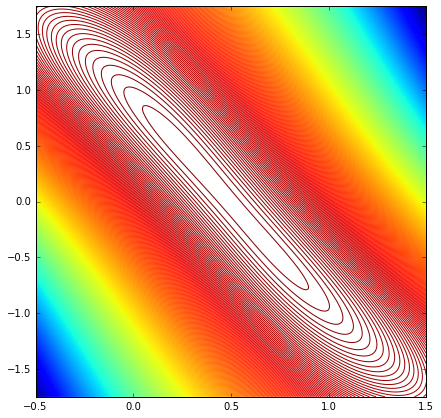

In [3]:
""" 
Heres a contour plot of the posterior, like Figure 1 in the SGLD paper.
The contour plot should roughly show a peak at (0,1) and (1,-1). It may not be exactly that,
but if we generate anywhere more than, say, 1000 points, we should almost certainly see the
two modes. Keep in mind that the 'K' parameter here will affect computation time, though this
gets computed fairly quickly (<2 minutes) even with K=200 and X having 100k data points.
"""

K = 200
T = 110 # Temperature
xlist = np.linspace(-0.5, 1.5, num=K)
ylist = np.linspace(-1.75, 1.75, num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = log_f(theta, X, N, T)        
plt.figure(figsize=(7,7))
plt.contour(X_a,Y_a,Z_a,500)

In [16]:
""" 
Now we run and compare algorithms. Let's start with random walk proposals. 
Actually, to make things easier to see, let's split up the algorithms one by one.
Use capital T, not t, because of the student t distribution conflict. Gaaaah.
One "pass" means one "minibatch" in which we evaluate a gradient.
"""

    
#######################################
# STANDARD MCMC WITH STANDARD MH TEST #
#######################################
num_passes = 10000
rw_eps = 0.03
temperature = 110
theta = np.array([[0.5],[0]])
all_1 = theta

# For diagnostical analysis
MH_accept_1 = []
MH_reject_1 = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Standard MH test. Note that it's just min{1, exp(\Delta')}.
    theta_new = theta + get_noise(rw_eps)        
    delta_real = get_delta(theta, theta_new, X, N, temperature)
    test = np.min([1, np.exp(delta_real)])
    u = np.random.random()
    
    # Just in case ...
    assert not np.isnan(np.exp(delta_real)), "delta_real={}".format(delta_real)
    assert not np.isnan(test), "test={}".format(test)
    assert 0 <= test <= 1, "test={}".format(test)
    
    # Now *finally* do the test!
    if (u < test):
        theta = theta_new
        MH_accept_1.append(T)
    else:
        MH_reject_1.append(T)
    all_1 = np.concatenate((all_1,theta), axis=1)
        
print("\nDone with the standard minibatch MCMC test.\n")


#######################################
# STANDARD MCMC WITH STANDARD MH TEST #
#######################################
num_passes = 10000
rw_eps = 0.03
temperature = 110
mb_size = 20
theta = np.array([[0.5],[0]])
all_5 = theta

# For diagnostical analysis
MH_accept_2 = []
MH_reject_2 = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Standard MH test. Note that it's just min{1, exp(\Delta')}.
    theta_new = theta + get_noise(rw_eps)       
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mini, N, temperature)    
    test = np.min([1, np.exp(delta_real)])
    u = np.random.random()
    
    # Just in case ...
    assert not np.isnan(np.exp(delta_real)), "delta_real={}".format(delta_real)
    assert not np.isnan(test), "test={}".format(test)
    assert 0 <= test <= 1, "test={}".format(test)
    
    # Now *finally* do the test!
    if (u < test):
        theta = theta_new
        MH_accept_2.append(T)
    else:
        MH_reject_2.append(T)
    all_5 = np.concatenate((all_5,theta), axis=1)
        
print("\nDone with the SECOND standard minibatch MCMC test.\n")


######################################################
# CUTTING MH BUDGET (should be good, if inefficient) #
######################################################
num_passes = 10000
rw_eps = 0.03
temperature = 110
mb_size = 200
theta = np.array([[0],[1]])
all_2 = theta
tolerance = 0.1

# For cutting the MH (aka approx MH)
cutting_MH_sizes_accept = []
cutting_MH_sizes_reject = []
cutting_MH_accept = []
cutting_MH_reject = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's deal with the Approx_MH test. This returns a boolean to accept (True) or not.
    # With a random walk proposal, the mu_0 does not depend on the likelihood information.
    theta_new = theta + get_noise(rw_eps)
    prior_old = log_f_prior(theta)
    prior_new = log_f_prior(theta_new)
    log_u = np.log(np.random.random())
    mu_0 = (1.0/N) * (log_u + prior_old - prior_new)    
    (do_we_accept,this_mb_size) = approximate_mh_test(
        theta, theta_new, mb_size, X, N, mu_0, tolerance, temperature)
    
    assert not np.isnan(prior_old)
    assert not np.isnan(prior_new)
    assert not np.isnan(log_u)
    assert not np.isnan(mu_0)
    assert this_mb_size >= mb_size
    
    if do_we_accept:
        theta = theta_new
        cutting_MH_sizes_accept.append(this_mb_size)
        cutting_MH_accept.append(T)
    else:
        cutting_MH_sizes_reject.append(this_mb_size)
        cutting_MH_reject.append(T)
    all_2 = np.concatenate((all_2,theta), axis=1)
        
print("\nDone with the adaptive sampling method!\n")


###################
# OUR MH TEST (1) #
###################
num_passes = 10000
rw_eps = 0.03
temperature = 110
mb_size = 200
theta = np.array([[0.5],[0]])
num_samples_delta = 5 # The number of instances of \Delta we collect
mavg = 0.7 # Moving average
sd = 0
all_3 = theta

# For diagnostical analysis
our_MH_accept_1 = []
our_MH_reject_1 = []
our_sds_1 = []
our_deltas_1 = []
our_xcorrs_1 = []
total_skip = 0

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's get *one* new theta, and use multiple mini-batches for this to estimate std. 
    theta_new = theta + get_noise(rw_eps)
    delta_list = []
    """
    
    for k in range(num_samples_delta):
        X_minibatch = X[np.random.choice(N, mb_size, replace=False)]
        delta_new = get_delta(theta, theta_new, X_minibatch, N, temperature)
        delta_list.append(delta_new)
    this_est_std = np.std(np.array(delta_list))
    """
    
    # OK, now we have to be careful with our est_std. Still, add diagnostics...
    # If we know the future moving average is too large ... let's not do a moving average!
    this_est_std = estimateVar_from_one_batch (theta, theta_new, X_mini_batch, N, temperature)**0.5
    projected_mavg = this_est_std
    if (projected_mavg >= 1.188):
        print("Iteration {}, sd {}, re-using...".format(T, projected_mavg))
        total_skip += 1
        our_sds_1.append(projected_mavg)
        our_MH_reject_1.append(T)
        all_3 = np.concatenate((all_3,theta), axis=1)
        continue
    
    # Now we update the moving average and take advantage of pre-computed data.
    sd = this_est_std
    X_corr = get_rand_xcorr(ecdfmat, sd_vect, sd)
    
    # Using this *same* theta, let's get another mini-batch and another delta, but "for real".
    X_mb_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mb_real, N, temperature)
  
    # Gather data for diagnostics.
    our_deltas_1.append(delta_real)
    our_sds_1.append(sd)
    our_xcorrs_1.append(X_corr)
    
    # Now *finally* do the test!
    if (X_corr + delta_real > 0):
        theta = theta_new
        our_MH_accept_1.append(T)
    else:
        our_MH_reject_1.append(T)
    all_3 = np.concatenate((all_3,theta), axis=1)
        
print("\nDone with our MH test!\n")


#####################################################
# All done. Let's print some interesting statistics #
#####################################################
print("\nAll done!")
print("(Standard MH) accepted {} times, rejected {} times".
      format(len(MH_accept_1), len(MH_reject_1)))
print("(Cutting MH) accepted {} times, rejected {} times".
      format(len(cutting_MH_accept), len(cutting_MH_reject)))
print("(Our MH) accepted {} times, rejected {} times".
      format(len(our_MH_accept_1), len(our_MH_reject_1)))
print("skipped = {}".format(total_skip))

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with the standard minibatch MCMC test.

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with the SECOND standard minibatch MCMC test.

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000
T=9500

Done with the adaptive sampling method!

Iteration 7, sd 1.68271051608, re-using...
Iteration 14, sd 1.43036303592, re-using...
Iteration 19, sd 1.85639336973, re-using...
Iteration 20, sd 1.89551677279, re-using...
Iteration 24, sd 1.19390804908, re-using...
Iteration 25, sd 1.34407847843, re-using...
Iteration 35, sd 2.62914717683, re-using...
Iteration 41, sd 1.25984508428, re-using...
Iteration 57, sd 1.37236969899, re-using...
Iteration 61, sd 1.87348635639, re-using...
Iteration 62, sd 2.64681

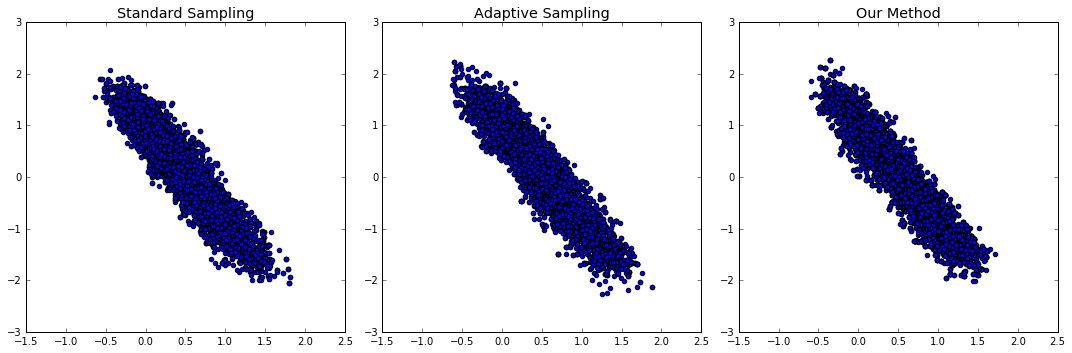

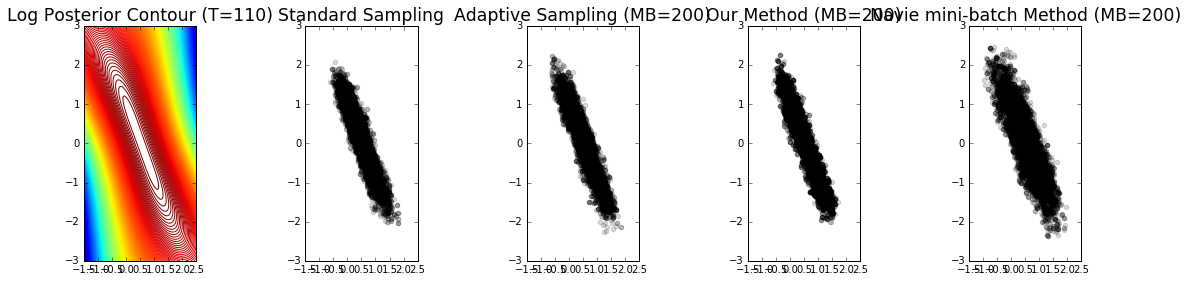

In [18]:
# Plot everything. Be careful that we're using all_x with the correct 'x' values.
fig, axarr = plt.subplots(1,3, figsize=(15, 5))

axarr[0].set_title("Standard Sampling", size="x-large")
axarr[0].scatter(all_1[0], all_1[1])#color = m_c2, alpha=1)
axarr[0].set_xlim([-1.5,2.5])
axarr[0].set_ylim([-3,3])

axarr[1].set_title("Adaptive Sampling", size="x-large")
axarr[1].scatter(all_2[0], all_2[1])#color = m_c2, alpha=1)
axarr[1].set_xlim([-1.5,2.5])
axarr[1].set_ylim([-3,3])

axarr[2].set_title("Our Method", size="x-large")
axarr[2].scatter(all_3[0], all_3[1])#, color = m_c2, alpha=1)
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])

plt.tight_layout()
plt.savefig('scatter_v01.png', dpi=200)


# Here's another version, this time with a color map meshed.
mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)
fig, axarr = plt.subplots(1,5, figsize=(16, 4))

axarr[0].set_title("Log Posterior Contour (T=110)", size="xx-large")
K = 200
T = 110 # Temperature
xlist = np.linspace(-1.5,2.5,num=K)
ylist = np.linspace(-3,3,num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = log_f(theta, X, N, T)        
axarr[0].contour(X_a,Y_a,Z_a,300)

axarr[1].set_title("Standard Sampling", size="xx-large")
axarr[1].scatter(all_1[0], all_1[1], color = m_c2, alpha=0.15)
axarr[1].set_xlim([-1.5,2.5])
axarr[1].set_ylim([-3,3])

axarr[2].set_title("Adaptive Sampling (MB=200)", size="xx-large")
axarr[2].scatter(all_2[0], all_2[1], color = m_c2, alpha=0.15)
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])

axarr[3].set_title("Our Method (MB=200)", size="xx-large")
axarr[3].scatter(all_3[0], all_3[1], color = m_c2, alpha=0.15)
axarr[3].set_xlim([-1.5,2.5])
axarr[3].set_ylim([-3,3])

axarr[4].set_title("Navie mini-batch Method (MB=200)", size="xx-large")
axarr[4].scatter(all_5[0], all_5[1], color = m_c2, alpha=0.15)
axarr[4].set_xlim([-1.5,2.5])
axarr[4].set_ylim([-3,3])

plt.tight_layout()
plt.savefig('cloud_v01.png', dpi=200)

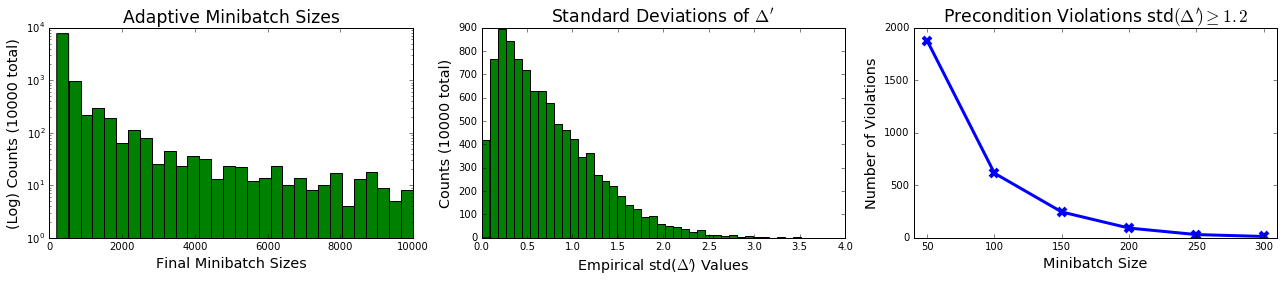

In [19]:
""" Plot results. """

# UDPATE! Using this as a new figure:
fig, axarr = plt.subplots(1,3, figsize=(18, 4))

axarr[0].set_title("Adaptive Minibatch Sizes", size="xx-large")
axarr[0].hist(cutting_MH_sizes_accept + cutting_MH_sizes_reject, bins=30, facecolor ='green')
axarr[0].set_xlabel("Final Minibatch Sizes", size="x-large")
axarr[0].set_ylabel("(Log) Counts (10000 total)", size="x-large")
#axarr[0].set_ylim([0,600]) # Peaks at 8000
axarr[0].set_xlim([0,10000])
axarr[0].set_yscale('log')

axarr[1].set_title("Standard Deviations of $\Delta'$", size="xx-large")
axarr[1].hist(our_sds_1, bins=40, facecolor ='green')
axarr[1].set_xlabel("Empirical std($\Delta'$) Values", size="x-large")
axarr[1].set_ylabel("Counts (10000 total)", size="x-large")

axarr[2].set_title("Precondition Violations std$(\Delta') \geq 1.2$", size="xx-large")
axarr[2].set_xlim([40,310])
axarr[2].set_xlabel("Minibatch Size", size="x-large")
axarr[2].set_ylabel("Number of Violations", size="x-large")
res = [1877, 614.4, 245.8, 92.6, 30.6, 12.8]
std = [50.67, 53.78, 15.84, 8.75, 5.85, 2.31]
# Error bars are too small to see ...
#axarr[2].errorbar([50,100,150,200,250,300], res, yerr=std, fmt='b-', lw=2, ms=8, mew=4)
axarr[2].plot([50,100,150,200,250,300], res, 'b-x', lw=3, ms=8, mew=4)

plt.tight_layout()
plt.savefig('adaptive_and_ours_information_v01.png', dpi=200)

In [3]:
# UPDATE: Use this to run with more minibatches but with the same settings as earlier, 
# so I can keep track of the minibatch effect on the 'skipping' rate.
num_passes = 1000
rw_eps = 0.03
temperature = 110
mb_size = 50
theta = np.array([[0.5],[0]])
num_samples_delta = 5 # The number of instances of \Delta we collect
mavg = 0.7 # Moving average
sd = 0
all_3 = theta

# For diagnostical analysis
our_MH_accept_1 = []
our_MH_reject_1 = []
our_sds_1 = []
our_deltas_1 = []
our_xcorrs_1 = []
total_skip = 0

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's get *one* new theta, and use multiple mini-batches for this to estimate std. 
    theta_new = theta + get_noise(rw_eps)
    # do the bootstrap to estimate the sd of var(delta)
    delta_list = []
    for k in range(num_samples_delta):
        X_minibatch = X[np.random.choice(N, mb_size, replace=False)]
        delta_new = get_delta(theta, theta_new, X_minibatch, N, temperature)
        delta_list.append(delta_new)
    this_est_std = np.std(np.array(delta_list))
    
    # OK, now we have to be careful with our est_std. Still, add diagnostics...
    # If we know the future moving average is too large ... let's not do a moving average!
    projected_mavg = mavg*sd + (1-mavg)*this_est_std
    if (projected_mavg >= 1.188):
        #print("Iteration {}, sd {}, re-using...".format(T, projected_mavg))
        total_skip += 1
        our_sds_1.append(projected_mavg)
        our_MH_reject_1.append(T)
        all_3 = np.concatenate((all_3,theta), axis=1)
        continue
    
    # Now we update the moving average and take advantage of pre-computed data.
    sd = mavg*sd + (1-mavg)*this_est_std
    X_corr = get_rand_xcorr(ecdfmat, sd_vect, sd)
    
    # Using this *same* theta, let's get another mini-batch and another delta, but "for real".
    X_mb_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mb_real, N, temperature)
  
    # Gather data for diagnostics.
    our_deltas_1.append(delta_real)
    our_sds_1.append(sd)
    our_xcorrs_1.append(X_corr)
    
    # Now *finally* do the test!
    if (X_corr + delta_real > 0):
        theta = theta_new
        our_MH_accept_1.append(T)
    else:
        our_MH_reject_1.append(T)
    all_3 = np.concatenate((all_3,theta), axis=1)
        
print("\nDone with our MH test! total_skip = {}.".format(total_skip))

T=500
T=1000
T=1500
T=2000
T=2500
T=3000
T=3500
T=4000
T=4500
T=5000
T=5500
T=6000
T=6500
T=7000
T=7500
T=8000
T=8500
T=9000


KeyboardInterrupt: 

In [49]:
# Daniel: array of values to report for mb sizes 50, 100, 150, 200, 250, and 300.
a = np.array([[1830, 1967, 1879, 1882, 1827],
              [542, 673, 597, 580, 680],
              [231, 246, 239, 276, 237],
              [88, 96, 98, 103, 78],
              [35, 22, 38, 32, 26],
              [13, 14, 16, 12, 9]])
print(a)
print(np.mean(a, axis=1))
print(np.std(a, axis=1))

[[1830 1967 1879 1882 1827]
 [ 542  673  597  580  680]
 [ 231  246  239  276  237]
 [  88   96   98  103   78]
 [  35   22   38   32   26]
 [  13   14   16   12    9]]
[ 1877.    614.4   245.8    92.6    30.6    12.8]
[ 50.671491    53.78698727  15.84171708   8.75442745   5.85149554
   2.31516738]


In [90]:
a = np.where(np.array(cutting_MH_sizes_accept + cutting_MH_sizes_reject) == 400)
print a[0].shape

(1240,)


In [76]:
"""
In this block, we test our sd smooth is correct or not
We also generate a CI for the sd(delta) by bootstrap method
"""

###################################
# OUR MH TEST for estimate the sd #
###################################
num_passes = 10000
rw_eps = 0.03
temperature = 110
mb_size = 200
theta = np.array([[0.5], [0]])
num_samples_delta = 20 # The number of instances of \Delta we collect
mavg = 0.7 # Moving average
sd = 0
all_3 = theta

# For diagnostical analysis
our_MH_accept_1 = []
our_MH_reject_1 = []
our_sds_1 = []
our_deltas_1 = []
our_xcorrs_1 = []
total_skip = 0
our_estimate_sd = []
actual_sd = []

for T in range(1,num_passes):
    if (T % int(num_passes/20) == 0):
        print("T={}".format(T))
        
    # Let's get *one* new theta, and use multiple mini-batches for this to estimate std. 
    theta_new = theta + get_noise(rw_eps)
    delta_sd_list = []
    for k in range(num_samples_delta):
        X_minibatch = X[np.random.choice(N, mb_size, replace=False)]
        
        # delta_new = get_delta(theta, theta_new, X_minibatch, N, temperature)
        delta_sd_list.append(estimateVar_from_one_batch (theta, theta_new, X_minibatch, N, temperature) **0.5)
    our_estimate_sd.append(np.std(np.array(delta_sd_list)))
    
    X_mini_batch = X[np.random.choice(N, mb_size, replace=False)]
    sd = estimateVar_from_one_batch (theta, theta_new, X_minibatch, N, temperature) **0.5
    actual_sd.append(sd)
    if (sd >= 1.188):
        print("Iteration {}, sd {}, re-using...".format(T, sd))
        total_skip += 1
        our_sds_1.append(sd)
        our_MH_reject_1.append(T)
        all_3 = np.concatenate((all_3,theta), axis=1)
        continue
    
    # Now we update the moving average and take advantage of pre-computed data.
    # sd = mavg*sd + (1-mavg)*this_est_std
    X_corr = get_rand_xcorr(ecdfmat, sd_vect, sd)
    
    # Using this *same* theta, let's get another mini-batch and another delta, but "for real".
    X_mb_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_real = get_delta(theta, theta_new, X_mb_real, N, temperature)
  
    # Gather data for diagnostics.
    our_deltas_1.append(delta_real)
    our_sds_1.append(sd)
    our_xcorrs_1.append(X_corr)
    
    # Now *finally* do the test!
    if (X_corr + delta_real > 0):
        theta = theta_new
        our_MH_accept_1.append(T)
    else:
        our_MH_reject_1.append(T)
    all_3 = np.concatenate((all_3,theta), axis=1)
        
print("\nDone with our MH test!\n")



Iteration 1, sd 2.09650954181, re-using...
Iteration 2, sd 1.68765666448, re-using...
Iteration 4, sd 1.47625662765, re-using...
Iteration 11, sd 1.3863090866, re-using...
Iteration 16, sd 1.53243727521, re-using...
Iteration 32, sd 1.38134257446, re-using...
Iteration 38, sd 2.30105737088, re-using...
Iteration 42, sd 1.93416453283, re-using...
Iteration 43, sd 1.67441157827, re-using...
Iteration 45, sd 1.29656702504, re-using...
Iteration 48, sd 1.20772156495, re-using...
Iteration 52, sd 1.61125052428, re-using...
Iteration 82, sd 1.6640502833, re-using...
Iteration 85, sd 1.20082748929, re-using...
Iteration 89, sd 1.44696333563, re-using...
Iteration 92, sd 1.82753365311, re-using...
Iteration 102, sd 1.3194565974, re-using...
Iteration 108, sd 1.96981625999, re-using...
Iteration 114, sd 1.85134865774, re-using...
Iteration 115, sd 1.38492986287, re-using...
Iteration 124, sd 1.59179326829, re-using...
Iteration 130, sd 1.59568081762, re-using...
Iteration 132, sd 1.48752465581,

In [50]:
def moving_avg (targetArray, windownSize):
    n = len(targetArray)
    res = []
    i = windownSize / 2
    while (i < n - windownSize/2):
        res.append(np.mean(targetArray[(i-windownSize/2):(i+windownSize/2)]))
        i+=1
    return res
            
        

In [72]:
CI_sd_draw = moving_avg(our_estimate_sd, 150)
actual_sd_draw = moving_avg(actual_sd, 150)

inten = 100
x = [i*inten for i in range(len(CI_sd_draw)/inten)]
CI_sd_draw = np.asarray([CI_sd_draw[i*inten] for i in range(len(CI_sd_draw)/inten)])
actual_sd_draw = np.asarray([actual_sd_draw[i*inten] for i in range(len(actual_sd_draw)/inten)])
sd_up = actual_sd_draw + CI_sd_draw
sd_down = actual_sd_draw - CI_sd_draw


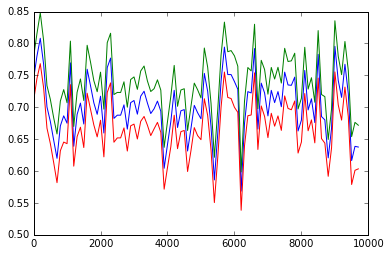

In [75]:
plt.plot(x, actual_sd_draw)
plt.plot(x, sd_up)
plt.plot(x, sd_down)
plt.show()

[ 0.05394107  0.06262395  0.06837495 ...,  0.07108987  0.07595373
  0.05588481]


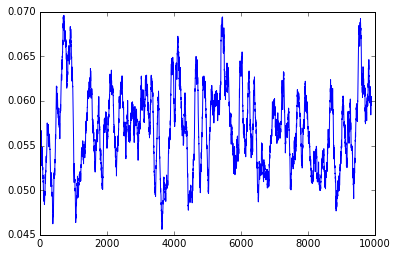

In [74]:
tmp  = np.asarray(our_estimate_sd) / np.asarray(actual_sd)
print tmp
tmp = moving_avg(tmp, 100)
plt.plot(tmp)

0.163489694823
1.02895143964


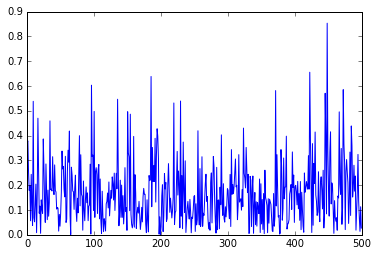

(0, 1)

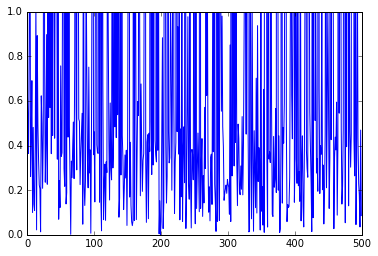

In [29]:
our_estimate_sd = np.asarray(our_estimate_sd)
actual_sd = np.asarray(actual_sd)

diff = np.abs(our_estimate_sd - actual_sd)
relative_diff = diff/ actual_sd
print np.mean(diff)
print np.mean(relative_diff)
plt.plot(diff[0:500])
plt.show()
plt.plot(relative_diff[0:500])
plt.ylim([0,1])

10000

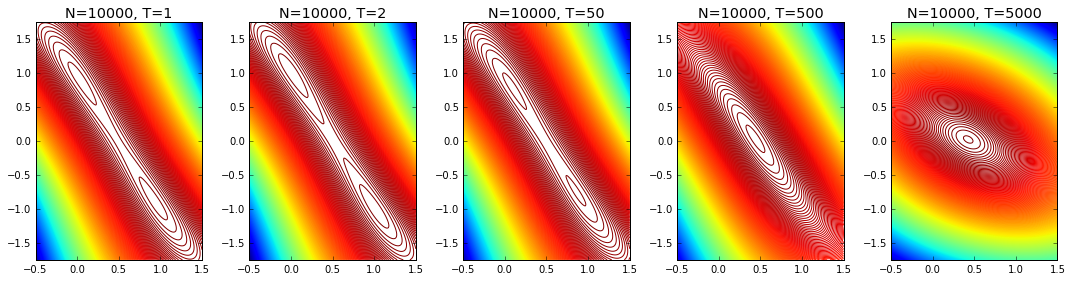

In [ ]:
""" Let's actually try investigating the multimodality of the posterior. """

# Generate the data according to Section 5.1 of "Bayesian Learning via SGLD" (2011).
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Get contour plot parameters here.
K = 200
num_contours = 400

# We need these for the plot, though we'll recreate them inside each get_contours method.
# Make sure the 'linspace' is set correctly!!
xlist = np.linspace(-0.5, 1.5, num=K)
ylist = np.linspace(-1.75, 1.75, num=K)
X_coords,Y_coords = np.meshgrid(xlist, ylist)
    
# Temperature
# T = 1


def get_contours(N, T, K):
    """ Given N and a temperature parameter, generate the Z needed for contour plots. """
    xlist = np.linspace(-0.5, 1.5, num=K)
    ylist = np.linspace(-1.75, 1.75, num=K)
    X_coords,Y_coords = np.meshgrid(xlist, ylist)
    
    # Data generation.
    X = np.zeros(N)    
    for i in xrange(N):
        u = np.random.random()
        if (u < 0.5):
            X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
        else:
            X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))    
    
    # Getting information for plots.
    Z = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            theta = np.array( [[X_coords[i,j]],[Y_coords[i,j]]] )
            Z[i,j] = log_f(theta, X, N, T) 
    return Z

# Different contours.
z0 = get_contours(10000, 1, K)
z1 = get_contours(10000, 2, K)
z2 = get_contours(10000, 50, K)
z3 = get_contours(10000, 500, K)
z4 = get_contours(10000, 5000, K)

## Now plot everything!!
fig, axarr = plt.subplots(1,5, figsize=(15, 4))
axarr[0].set_title('N=10000, T=1', size='x-large')
axarr[0].contour(X_coords,Y_coords,z0,num_contours)
axarr[1].set_title('N=10000, T=2', size='x-large')
axarr[1].contour(X_coords,Y_coords,z1,num_contours)
axarr[2].set_title('N=10000, T=50', size='x-large')
axarr[2].contour(X_coords,Y_coords,z2,num_contours)
axarr[3].set_title('N=10000, T=500', size='x-large')
axarr[3].contour(X_coords,Y_coords,z3,num_contours)
axarr[4].set_title('N=10000, T=5000', size='x-large')
axarr[4].contour(X_coords,Y_coords,z4,num_contours)
plt.tight_layout()
plt.savefig('contour_v2.png', dpi=200)

In [ ]:
""" Now let's do some KL divergence testing """

def estimate_kl_divergence(all_thetas, d_space, full_data, temp, contour=False):
    """
    Given a sequence of \theta values that we have sampled, we compuare this with the
    distribution from log_f by the estimated KL divergence. We discretize the bin of
    possible theta values so that this reduces to a discrete distribution. We do,
    however, smooth the distribution by adding a count of 0.1 to each slot.
        
    all_thetas: A (2 x K) numpy array of \theta values that were accepted into our chain.
        Note that following previous convention, we assume that we *repeat* certain theta
        values. During some iterations, we reject the proposed sample \theta', but we
        should repeat the current \theta_t as \theta_{t+1} if that is the case. This does
        not matter for visualizing a scatter plot (they'll be on the same point) but it
        matters when attempting to compute the KL divergence.
    d_scale: A scalar which determines how far we discretize the theta values. It should
        be on the order of, perhaps, 0.05. Actually, one should probably make this align
        with the min_x, max_x, etc. values.
    full_data: Our 'X' matrix (well, vector) from before, with the N data points. It
        could also be a subset, but probably best to use the full data like we did with
        the contour plots.
    temp: The temperature parameter.
    contour: If we want to print a contour or not.
      
    Returns: the estimate of the KL divergence.
    """
    
    (m,n) = all_thetas.shape
    assert m == 2
    assert 0.001 <= d_space <= 1.0 
    
    # Let's deal with the grid limits and perform any necessary clipping of data.
    (min_x, max_x) = (-1.0, 2.0)
    (min_y, max_y) = (-2.5, 2.5)
    clipped_thetas = np.zeros((m,n))
    clipped_thetas[0] = np.maximum( np.minimum(all_thetas[0], max_x), min_x )
    clipped_thetas[1] = np.maximum( np.minimum(all_thetas[1], max_y), min_y )
    
    # Round each element in clipped_thetas to its nearest multiple within d_space.
    thetas_rounded = d_space * np.rint(clipped_thetas/d_space)
    
    # Form the grid of points. Add d_space because arange doesn't include the last element.
    x_coords = np.arange(min_x, max_x + d_space, d_space)
    y_coords = np.arange(min_y, max_y + d_space, d_space)
    num_x = len(x_coords)
    num_y = len(y_coords)
    
    # Deal with the source distribution, which calls our function. Exponentiate later.
    source_distribution = np.zeros((num_x,num_y))
    for xc in range(num_x):
        for yc in range(num_y):
            (theta1,theta2) = (x_coords[xc],y_coords[yc])
            this_theta = np.array([[theta1],[theta2]])
            source_distribution[xc,yc] = log_f(this_theta, full_data, len(full_data), temp)
            assert not np.isnan(source_distribution[xc,yc])
    source_distribution = np.exp(source_distribution)
    
    # Do the target distribution, iterating through theta_rounded. Do NOT exponentiate!
    target_distribution = np.zeros((num_x,num_y))
    for theta in thetas_rounded.T: 
        # Note the transpose above. Given theta, multiply by d_space to get integer coords.
        (xt,yt) = np.rint(theta*d_space)
        target_distribution[xt,yt] = target_distribution[xt,yt] + 1
    
    # Smooth the distributions by adding in a small constant, then normalize.
    eps = 0.01
    source_distribution = source_distribution + eps
    target_distribution = target_distribution + eps
    source_distribution = source_distribution / np.sum(source_distribution)
    target_distribution = target_distribution / np.sum(target_distribution)
    
    # Finally, compute an estimate of the KL divergence.
    kldiv = 0.0
    for xc in range(num_x):
        for yc in range(num_y):
            p_xy = source_distribution[xc,yc]
            q_xy = target_distribution[xc,yc]
            kldiv += (p_xy)*(np.log(p_xy) - np.log(q_xy))
            assert not np.isnan(kldiv)
            
    # If I want to print contour plots of this. EDIT: Not working right now ...
    if contour:
        print("Not yet implemented")
        
    # Return what we want all along.
    return kldiv


discretization = 0.1
temp = 1
print(estimate_kl_divergence(all_1, discretization, X, temp))
print(estimate_kl_divergence(all_2, discretization, X, temp))
print(estimate_kl_divergence(all_3, discretization, X, temp))
print(estimate_kl_divergence(all_4, discretization, X, temp))

3.80711079733
5.35629120113
5.34856903958